In [4]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.fftpack import rfft, fftshift

# oops, turns out, we've used different devices when collected eeg, therefore different sampling rates for 
# different records
sampling_rates_for_record_numbers = { 
    220: [1, 2, 3, 4, 5, 13, 14, 15],
    256: [6, 7, 8, 9, 10, 11, 12]
}

EEG_BANDS = {'delta_absolute': (3, 4),
             'theta_absolute': (4, 8),
             'alpha_absolute': (7.5, 13),
             'beta_absolute': (13, 30),
             'gamma_absolute': (30, 44)}


def log_power_spectrum_extractor(df, win_len, shift_len, sampling_rate):
    samples = df.shape[0]
    frames = (samples - win_len) // shift_len
    
    results = np.zeros((frames, 21), dtype=np.float64)
    
    for j, column in enumerate(['eeg_1', 'eeg_2', 'eeg_3', 'eeg_4']):
        data = np.array(df[column])
        for i in range(frames):
            frame_start = i*shift_len
            frame_end = i*shift_len+win_len
            one_frame = data[frame_start: frame_end]
            freqs, psd = signal.welch(one_frame, fs=sampling_rate, window='hamming')
            band_abs_values = []
            for band in EEG_BANDS:  
                freq_ix = np.where((freqs >= EEG_BANDS[band][0]) & 
                                   (freqs <= EEG_BANDS[band][1]))[0]
                band_abs_values.append(np.log10(np.sum(psd[freq_ix])))
            results[i, 0] = df['timestamps'][frame_end]
            index_start = 5 * j + 1
            results[i, index_start: index_start + 5] = band_abs_values
    df = pd.DataFrame(results, columns=['timestamps'] + ['%s_%d' % (key, num) for num in range(1, 5) 
                                                         for key in EEG_BANDS.keys()])
    # compute avg scores across all channels, or process df in any other way
    return df


def process_raw_eeg(file_name):
    sampling_rate = 220 # see table with sampling number for different records
    shift_len = 22
    window_size = 256
    data = pd.read_csv(file_name)
    return log_power_spectrum_extractor(data, window_size, shift_len, sampling_rate)


In [6]:
res = process_raw_eeg('ref15_eeg.csv')
ref = pd.read_csv('ref15_abs_scores_1.csv')

In [7]:
res.head()

,timestamps,delta_absolute_1,theta_absolute_1,alpha_absolute_1,beta_absolute_1,gamma_absolute_1,delta_absolute_2,theta_absolute_2,alpha_absolute_2,beta_absolute_2,...,delta_absolute_3,theta_absolute_3,alpha_absolute_3,beta_absolute_3,gamma_absolute_3,delta_absolute_4,theta_absolute_4,alpha_absolute_4,beta_absolute_4,gamma_absolute_4
0,1.531744e+09,0.056703,0.896676,1.359389,1.163637,0.673849,-0.493854,0.435623,-0.062556,0.535818,...,-0.074634,0.796053,0.491466,0.678528,0.808034,-0.294249,0.705742,1.018003,1.015542,0.570470
1,1.531744e+09,0.107911,0.758352,1.261092,1.155015,0.760905,-1.417783,0.391083,0.085727,0.509815,...,0.323501,0.799711,0.438618,0.668249,0.847337,-0.266280,0.687886,0.987643,0.993743,0.558331
2,1.531744e+09,0.275555,0.620590,1.156489,1.167389,0.811124,-0.621566,0.327047,0.208485,0.492599,...,0.400343,0.846577,0.359530,0.678009,0.842252,-0.206225,0.625539,0.884796,0.968762,0.530691
3,1.531744e+09,0.290193,0.510151,1.048539,1.166456,0.810269,-0.310581,0.223282,0.288696,0.467017,...,0.298250,0.851901,0.240253,0.687215,0.783211,-0.208703,0.546702,0.727496,0.954713,0.499580
4,1.531744e+09,0.276069,0.581592,0.955903,1.156808,0.745975,-0.213264,0.113450,0.305711,0.454054,...,-0.170258,0.855449,0.084729,0.674237,0.678148,-0.094565,0.581836,0.542743,0.961774,0.493096


In [8]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

def plot_results(column):
    only_column = ref[[column, 'timestamps']].dropna()
    reference = pd.Series(only_column[column].values, index=pd.to_datetime(only_column['timestamps'], unit='s').values)
    computed = pd.Series(res[column].values, index=pd.to_datetime(res['timestamps'], unit='s').values)
    print('reference size %d' % reference.size)
    print('computed size %d' % computed.size)
    secs = mdates.SecondLocator()
    sec_fmt = mdates.DateFormatter('%S')

    plt.figure(1)
    ax1 = reference.plot(figsize=(20, 10), label='Reference %s in 1-st channel' % column, legend=True)
    plt.figure(2)
    ax2 = computed.plot(figsize=(20, 10), label='Computed %s in 1-st channel' % column, legend=True)
    
    ax1.xaxis.set_major_locator(secs)
    ax1.xaxis.set_major_formatter(sec_fmt)
    ax2.xaxis.set_major_locator(secs)
    ax2.xaxis.set_major_formatter(sec_fmt)
    
    

reference size 597
computed size 584


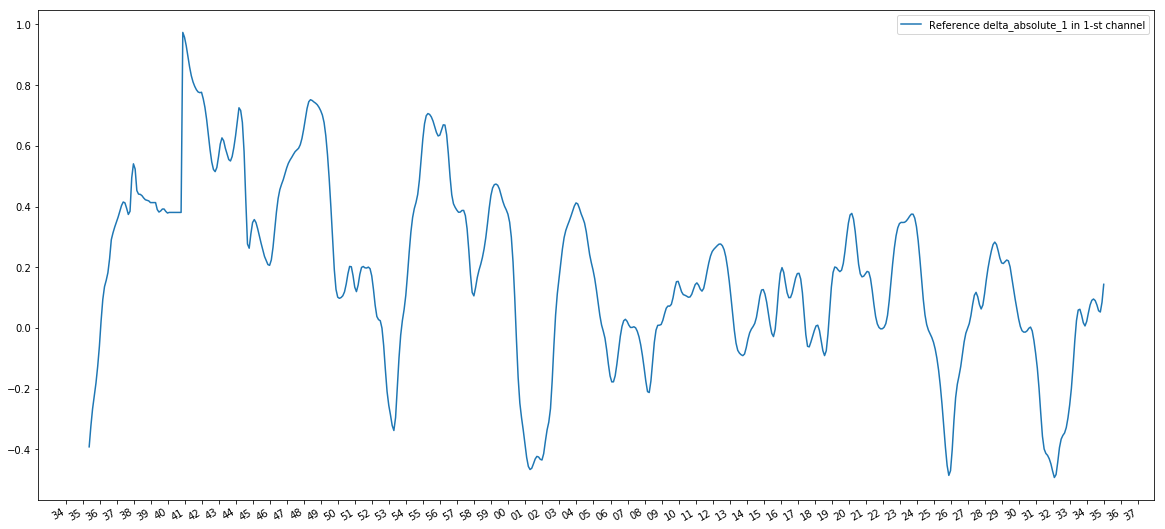

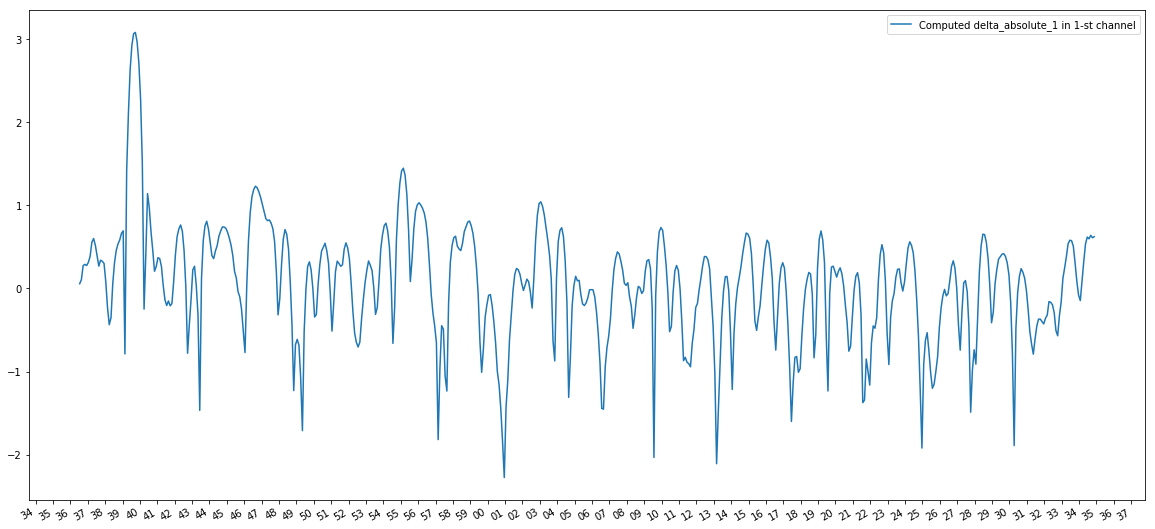

In [9]:
plot_results('delta_absolute_1')